In [1]:
!git clone https://github.com/mohamedmuzamil008/RAG_Workshop_DHS2024.git

Cloning into 'RAG_Workshop_DHS2024'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 190 (delta 84), reused 160 (delta 73), pack-reused 2 (from 1)
Receiving objects: 100% (190/190), 71.13 MiB | 21.91 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [2]:
!pip install -r /content/RAG_Workshop_DHS2024/rag_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

# Set logging for the queries
import logging

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.memory import ConversationBufferMemory
from typing import Dict, Any
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from IPython.display import Markdown

from RAG_Workshop_DHS2024.utils import pretty_print_result, pretty_print_docs

from langchain.retrievers import MergerRetriever, BM25Retriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import DocumentCompressorPipeline, EmbeddingsFilter, LLMChainFilter, LLMChainExtractor

from langchain.document_transformers  import EmbeddingsRedundantFilter
from langchain.retrievers.multi_query import MultiQueryRetriever

In [4]:
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_type = "openai"

## RAG Process Flow
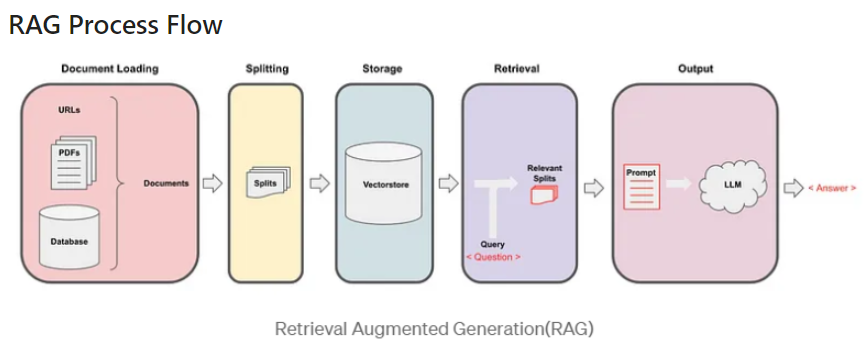



**Document Loading, Splitting and Storage**

In [5]:
# Document loading, splitting and storage
pdf_folder_path = os.getcwd() + "/RAG_Workshop_DHS2024/data/beazley/"

loaders = [PyPDFLoader(os.path.join(pdf_folder_path, fn)) for fn in os.listdir(pdf_folder_path)]

documents = []
for loader in loaders:
    # Loading
    print("Loading raw document..." + loader.file_path)
    raw_documents = loader.load()

    # Text splitting using Recursice text splitting
    print("Splitting the document..." + loader.file_path)
    r_splitter = RecursiveCharacterTextSplitter(
        chunk_size=100,
        chunk_overlap=20,
        separators=["\n\n", "\n", " ", ""]   # We pass a list of separators to RecursiveCharacterText Splitter
    )
    documents = r_splitter.split_documents(raw_documents)

    # Create embedding
    embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key)

    # Create the vector store
    print("Creating vector store..." + loader.file_path)
    persist_directory = os.getcwd() +'/vectorstore/beazley/'

    vectordb = Chroma.from_documents(
        documents=documents,
        embedding=embeddings,
        persist_directory=persist_directory
    )

Loading raw document.../content/RAG_Workshop_DHS2024/data/beazley/beazley_hy_report_2024_final.pdf
Splitting the document.../content/RAG_Workshop_DHS2024/data/beazley/beazley_hy_report_2024_final.pdf
Creating vector store.../content/RAG_Workshop_DHS2024/data/beazley/beazley_hy_report_2024_final.pdf
Loading raw document.../content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf
Splitting the document.../content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf
Creating vector store.../content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf
Loading raw document.../content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf
Splitting the document.../content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf
Creating vector store.../content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf
Loading raw document.../content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentatio

**Retrieval**

In [6]:
retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 3, "include_metadata": True})

**Augment**

In [42]:
template = """You are an intelligent assistant for question-answering tasks.
You are helping the user to get meaningful insights from the context provided.
Provide numbers or percentages wherever possible to the user so that he could understand the significance.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Avoid using generic phrases like "Provide context" or "as per context.
Take a deep breathe, think and answer step by step.

Question: {question}

Context: {context}

Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

**Memory**

In [8]:
class CustomConversationBufferMemory(ConversationBufferMemory):
    def save_context(self, inputs: Dict[str, Any], outputs: Dict[str, str]) -> None:
        return super(CustomConversationBufferMemory, self).save_context(inputs,{'response': outputs['answer']})

# define memory object
memory = CustomConversationBufferMemory(memory_key="chat_history", return_messages=True)

**LLM**

In [9]:
# Define the LLM
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

**Chain all together**

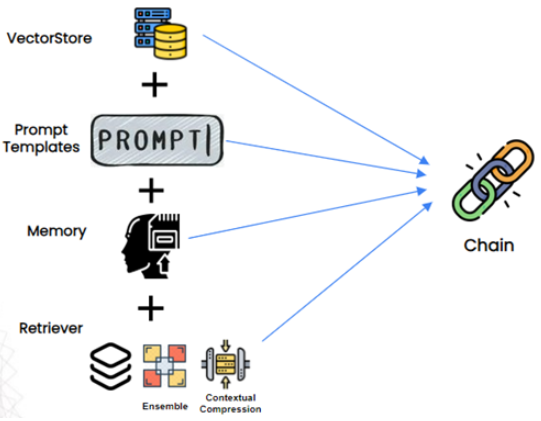

In [23]:
chain = ConversationalRetrievalChain.from_llm(llm=llm,
                                           combine_docs_chain_kwargs={"prompt": prompt},
                                          retriever=retriever,
                                           memory=memory,
                                           return_source_documents=True)

In [24]:
# Defining the template for the LLM response
def pretty_print_result_1(result):
    """
    Custom function to print clean output
    """
    display(Markdown("Answer: " + result["answer"]))
    print("=============================================================================================================")
    display(Markdown(f"\n{'-.' * 100}\n\n".join([f"Document {i+1}:\n\n" + d.page_content +"\n\n" + str(d.metadata) for i, d in enumerate(result['source_documents'])])))
    return

**Generate**

In [40]:
query = "Which line of business is having higher profitability in 2023?"
result = chain({"question": query})
pretty_print_result_1(result)

Answer: The context does not specify which line of business is experiencing higher profitability in 2023.

Document 1:

increase, reflected the growth of the business during 2023.

{'page': 63, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

their businesses. 
Outcomes from our engagement with clients and broker 
partners during 2023

{'page': 53, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

2023
• Our 5.3% margin at the end of 2022 would be towards the top

{'page': 17, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf'}

**Advanced RAG Retrieval**

**Using Filters, Compressors, Ensemble Retrievers and Multi-Query Retrievers**

In [28]:
# Hybrid retrieval using two different retrievers with two different search type.

# Semantic search retriever
retriever_1 = vectordb.as_retriever(search_type="similarity",
                                                 search_kwargs={"k": 5, "include_metadata": True}
                                                )

# BM25 Retriver for keyword based retrieval using BM25 algorithm
retriever_2 = BM25Retriever.from_documents(documents)
retriever_2.k = 5 # set the num of docs to be retrieved

# Hybrid Retriver using Semantic Search and Keyword search together
lotr = MergerRetriever(retrievers=[retriever_1, retriever_2])

In [29]:
# Redundancy Filter and Compressor
_filter = EmbeddingsRedundantFilter(embeddings=embeddings,similarity_threshold=0.85)
pipeline = DocumentCompressorPipeline(transformers=[_filter])
compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline,
                                                       base_retriever=lotr)

In [30]:
# Multi-Query Retriever
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

multi_query_retriever = MultiQueryRetriever.from_llm(retriever=compression_retriever,
                                                     llm=llm)

In [31]:
# Defining the template for the LLM response
def pretty_print_result_2(query, _llm, retriever):
    """
    Custom function to print clean output
    """
    advance_chain = ConversationalRetrievalChain.from_llm(llm=_llm,
                                           combine_docs_chain_kwargs={"prompt": prompt},
                                          retriever=retriever,
                                           memory=memory,
                                           return_source_documents=True)
    try:
      result = advance_chain({"question": query})
      display(Markdown("Answer: " + result["answer"].replace('$','`$`')))
      print("No of documents retrieved: " + str(len(result['source_documents'])))
      print("=============================================================================================================")
      display(Markdown(f"\n{'-.' * 100}\n\n".join([f"Document {i+1}:\n\n" + d.page_content.replace('$','`$`') +"\n\n" + str(d.metadata) for i, d in enumerate(result['source_documents'])])))
    except Exception as e:
        print(e)
        pass
    return

**Generate**

In [43]:
query = "Which line of business is having higher profitability in 2023?"
pretty_print_result_2(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ['What business sector is showing the most profit in 2023?  ', '', 'Which industry has the highest profitability rates this year?  ', '', 'In 2023, which line of business is yielding the greatest financial returns?']


Answer: In 2023, the property business is experiencing higher profitability, as indicated by its growth and the statement that it is the fastest growing platform. Additionally, there is a mention of a 5.3% margin at the end of 2022, which suggests a strong performance. The context also highlights that the overall profitability is currently positive, with the business being described as profitable. 

While specific numbers for profitability in 2023 are not provided, the emphasis on growth in the property sector and the positive indicators suggest that it is outperforming other lines of business.

No of documents retrieved: 30


Document 1:

profit and there is therefore no P&L impact.1

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 36}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Changes in estimates of future cashflows for business that is currently within the LRC.

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 36}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

•Year-end position includes the following year business plan and hence is lower than the half year

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 13}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

recession gives us confidence that we are well placed at the 
start of 2023.

{'page': 19, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2022_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

premium growth in the division on the Global Wholesale platform. Net premium growth is not

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 28}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

(2022: 12.9p) in March 2023.Future business developments

{'page': 142, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2022_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

Volatility continued to reduce as property business grew in 2023
220%10%20%30%40%50%60%

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 21}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

Specialty Risks 2.6 2.8

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 38}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 9:

5

{'page': 4, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 10:

1431 December 2023 `$`m* 31 December 2022 `$`m

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 13}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 11:

27

{'page': 26, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 12:

1st half 2nd half Investment Return

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 12}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 13:

L T I P  o u t t u r n s  i n  r e s p e c t  o f  2 0 2 2  ▪

{'page': 130, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2022_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 14:

(300.0)(200.0)(100.0)0.0100.0200.0300.0400.0500.0600.0
2019 2020 2021 2022 2023Investment result

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 12}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 15:

66.

{'page': 189, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2022_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 16:

104
34
13336
-3.0%-2.0%-1.0%0.0%1.0%2.0%3.0%4.0%5.0%6.0%

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 12}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 17:

are the discount rates at the stated duration

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 38}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 18:

performance or achievements of the Company, or industry results, to be materially different from

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 3}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 19:

Current indicators are that  the business is profitable.

{'page': 65, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2022_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 20:

capital.  This has the effect of reducing year on year gross

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 28}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 21:

*Gross premium has reduced due to the portfolio underwriting business now being written by

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 28}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 22:

higher than last year due to this year’s composition of profits 
and losses across the Group.

{'page': 57, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2021_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 23:

above market trend
Size of property opportunity makes 
this the fastest growing platform.

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 18}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 24:

2023 investment return was generated in the final two 
months of the year.

{'page': 64, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 25:

2023
• Our 5.3% margin at the end of 2022 would be towards the top

{'page': 17, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 26:

performance and financial condition of the Company and/or the Group. These forward -looking

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 3}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 27:

their businesses. 
Outcomes from our engagement with clients and broker 
partners during 2023

{'page': 53, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2023_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 28:

financial assumptions (Income)
•Change in discount rates is reasonably

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 37}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 29:

financial risk, which includes investment and underwriting. These are being monitored from 2023

{'page': 45, 'source': '/content/RAG_Workshop_DHS2024/data/beazley/beazley_annual_report_2022_final.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 30:

factors, known or unknown, which may cause the actual results,

{'source': '/content/RAG_Workshop_DHS2024/data/beazley/fy-results-presentation-2023.pdf', 'page': 3}